# Global Flood Validation Metrics Oct 4 2018 Updates
Written in Python 2

In [29]:
# This notebook was built in Catherine's vectorenv
import pandas as pd
from pandas import DataFrame
import numpy as np
import os
import glob
import datetime
#import pylabb
import matplotlib as plt
import datetime as datetime  
import statsmodels.api as sm  
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use('ggplot')

In [30]:
%matplotlib inline

# Data Preparation

In [31]:
path =r'/Users/ckuhn/Downloads/gfd_val/' # use your path
allFiles = glob.glob(path + "/*.csv")
df = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0, low_memory=False)
    list_.append(df)
df = pd.concat(list_)
df = df.drop(['system:index','.geo'], axis=1)

/Users/ckuhn/anaconda2/envs/vectorenv/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



**Validation** = student classification  
**Strata** = DFO classification 

The student classifiations were dividing into dry (0) and water (1). 

The model points were stratified into three classes or strata. They are 50% not flooded (permanent water + dry) and 50% flooded. 
- not flooded/dry (0)
- permanent water (1)
- flooded (2)

In [32]:
print('no. of unique floods:', len(df['dfoID'].unique()))
print(df.groupby(['method'])['dfoID'].count())
df.head(1)

no. of unique floods: 123
method
otsu_2day    34141
otsu_3day    34141
std_2day     34141
std_3day     34141
Name: dfoID, dtype: int64


,B1,B2,B3,B4,B5,B7,MNDWI,NDVI,analyst,date,...,lon,method,model_score,pixel_lat,pixel_lon,point_lat,point_lon,random,strata,validation
0,792.15651,896.579047,761.223987,1833.576595,980.842213,516.20095,-0.338543,0.408565,SiL,1.530000e+12,...,87.277107,otsu_2day,0.0,25.681778,87.277107,25.681778,87.277107,0.853473,0.0,0.0


## Cleaning

#### Drop floods with few points

In [35]:
#p= df.groupby('dfoID').filter(lambda g: g.dfoID.count() <= 250)

#### Drop NA points

In [36]:
# Pixels got labeled "NAN" were coded as either -99 or 99 
df = df.loc[df['validation'] > -1]
df = df.loc[df['validation'] < 99]

#### Make a score column

In [37]:
df['scaled_model_score'] = df['model_score'].multiply(2)
df['score']  = df['scaled_model_score'] + df['validation'] 

# Trying to make a loop!

In [38]:
methods = list(set(df.method))  # Get a list of the four methods
floods = list(set(df.dfoID)) ## Get a list of all the unique values of floods

col_names =  ['method','dfoID', 'val_points', 'tp', 'tn','fp','fn',
             'precision','recall','overall_accuracy',
             'commission','omission'] ### Column names for making data frames for each flood

my_df  = pd.DataFrame(columns = col_names)## Make empty data frame to put values for each sampling level in

for i in methods:  ### Loop through floods
    df_full = df.loc[df['method']== i] ### subset data frame by single flood
    for j in floods:
        df_subset = df_full.loc[df_full['dfoID']==j]
        tp = float(len(df_subset.loc[df_subset['score']== 5])) 
        tn = float(len(df_subset.loc[df_subset['score']== 0]))
        fp = float(len(df_subset.loc[df_subset['score']== 4]))
        fn = float(len(df_subset.loc[df_subset['score']== 1]))
        ### Calculating values!
        if tp == 0: ###Hmm, sometimes there are no tp scores, so you get a zero divide error
            continue ###I've put this in for now but it's gonna bite your butt eventually
        precision = tp / (tp + fp)
        recall  = tp / (tp + fn)  # % of flooded pixels it ID'ed correctly
        accuracy = (tn + tp) / (tn+tp+fp+fn)
        commission = fp / (tp + fp)  # modeled positives over all true positives
        omission = fn / (tp + fn)
        total_count = tp + fp + tn + fn
        ##add a new row to the dataframe based on this sampling level!
        my_df.loc[len(my_df)] = [i,j,total_count, tp, tn, fp, fn, precision, recall, accuracy, commission, omission]

        ###Now you should have a full dataframe with all your sampling levels for each flood
        ###SO
        
#Export Results
#%cd '/Users/ckuhn/Desktop/gfd_accuracy_rename/lumped/'
#Anna's original - my_df.to_csv('myprecious.csv', encoding='utf-8')
#my_df.to_csv('gfd_summary_validaton_metrics_resampled.csv', encoding='utf-8')

In [39]:
my_df.head(2)

,method,dfoID,val_points,tp,tn,fp,fn,precision,recall,overall_accuracy,commission,omission
0,std_3day,4098,185.0,116.0,58.0,9.0,2.0,0.928000,0.983051,0.940541,0.072000,0.016949
1,std_3day,2570,185.0,119.0,49.0,10.0,7.0,0.922481,0.944444,0.908108,0.077519,0.055556


In [40]:
len(my_df['dfoID'].unique())

119

In [41]:
my_df['method'].unique()

array(['std_3day', 'otsu_3day', 'otsu_2day', 'std_2day'], dtype=object)

### These ones don't process for some reason

In [50]:
a = my_df['dfoID'].values
b = df['dfoID'].values

res = list(set(s) - set(t))
res

[2640, 4428, 4357, 3094]

## Accuracy by method

In [15]:
# With all floods
print(my_df.groupby(['method'])['overall_accuracy'].median())

method
otsu_2day    0.834560
otsu_3day    0.805489
std_2day     0.857143
std_3day     0.860317
Name: overall_accuracy, dtype: float64


## Number of Points

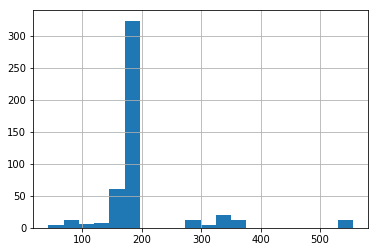

In [55]:
my_df['val_points'].hist(bins=20)

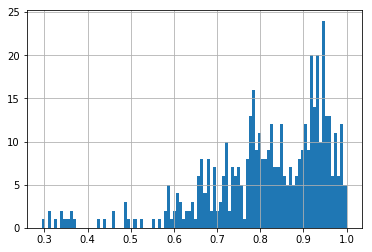

In [61]:
my_df['overall_accuracy'].hist(bins=100)

In [64]:
# Accuracies for Floods with < 200 points
drops = my_df.loc[my_df['val_points'] <= 150]
print(drops.groupby(['method'])['overall_accuracy'].median())
print(len(drops.dfoID.unique()))
#%cd '/Users/ckuhn/Desktop/'
#drops.to_csv('drop.csv', encoding='utf-8')  #aka my_df.to_csv('myprecious3.csv', encoding='utf-8')

method
otsu_2day    0.799107
otsu_3day    0.786607
std_2day     0.840580
std_3day     0.840580
Name: overall_accuracy, dtype: float64
9


In [65]:
# Accuracies for floods with > 200 points
keeps = my_df.loc[my_df['val_points'] >= 150]
print(keeps.groupby(['method'])['overall_accuracy'].median())
print(len(keeps.dfoID.unique()))

method
otsu_2day    0.834560
otsu_3day    0.808263
std_2day     0.859788
std_3day     0.864444
Name: overall_accuracy, dtype: float64
110


Text(0,0.5,'Overall Accuracy')

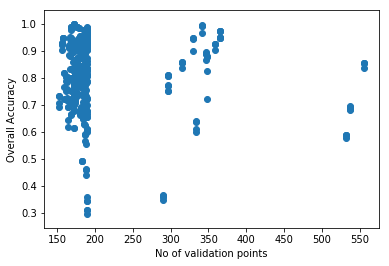

In [59]:
x = keeps['val_points']
y = keeps['overall_accuracy']

plt.scatter(x,y)
plt.xlabel('No of validation points')
plt.ylabel('Overall Accuracy')

### Analyze results

In [ ]:
# 59 floods
print('% of Floods with >90% accuracy', (len(my_df.loc[my_df['overall_accuracy'] >= 0.9]))/len(my_df))
print('% of Floods with >75% accuracy', (len(my_df.loc[my_df['overall_accuracy'] >= 0.75]))/len(my_df))
my_df['overall_accuracy'].describe()

# For 59 floods, mean accuracy is 82%, median accuracy is 86%, 75% of floods have 94% accuracy
    # 41% of the floods have 90% or better accuracy 
    # 73% of the flood have 80% or better accuracy 
# for 37 floods:  mean accuracy is 85%, median accuracy is 89%, 75% of the floods have 92% accuracy. 
    # and 49% of the floods have 90% or better accuracy 
    # 78% of the flood have 80% or better accuracy 

### Errors of Commission

In [ ]:
my_df['commission'].mean()

#From 37 floods: 0.22182899539761314
#From 59 floods: 0.25010345838907294

In [ ]:
params = {'axes.titlesize':'32',
          'xtick.labelsize':'24',
          'ytick.labelsize':'24'}
plt.rcParams.update(params)

# Go back to normal
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)  # to revert to default settings


my_df['commission'].hist(color='grey')
plt.ylabel('count', fontsize=24)
plt.xlabel('Rate of Commission Errors', fontsize=24)

plt.axvline(x=0.22182899539761314, color='grey', ls='--')
plt.axvline(x=0.25010345838907294, color='black', ls='--')
plt.axvline(x=0.22571967003363858, color='red', ls='--')

# mean errors of commission is 25%, 

#%cd /Users/ckuhn/Desktop/gfd_accuracy_rename/figures/
#plt.savefig('GFD_overall_commission.png', dpi = 300)

### Errors of Omission

In [ ]:
my_df['omission'].mean()

#From 37 floods: 0.02238782782112279
#From 59 floods: 0.022641702349266005
#From 123 floods: 0.07820311928541382

In [ ]:
my_df['omission'].hist(color='grey')
plt.ylabel('count', fontsize=24)
plt.xlabel('Errors of Omission', fontsize=24)
plt.axvline(x=0.02238782782112279, color='grey', ls='--')
plt.axvline(x=0.022641702349266005, color='black', ls='--')
plt.axvline(x=0.07820311928541382, color='red', ls='--')

%cd /Users/ckuhn/Desktop/gfd_accuracy_rename/figures
plt.savefig('GFD_overall_omission.png', dpi = 300)

In [ ]:
#my_df.groupby(['dfoID','method'])['overall_accuracy'].mean()

In [ ]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    plt.rc("font", family="Times New Roman", size = 22)
    plt.rc('xtick', labelsize=22) 
    plt.rc('ytick', labelsize=22) 
set_style()  

fig, ax = plt.subplots(figsize=(20,7))


my_df.groupby(['dfoID'])['overall_accuracy'].mean().plot(kind='bar', color='grey')
plt.ylabel('Overall Accuracy', fontsize = 30)
plt.xlabel('DFO ID', fontsize = 30)
plt.axhline(y=0.9, color='red', ls='--')
plt.axhline(y=0.82, color='black', ls='-')

plt.axhline(y=0.75, color='#FFA07A', ls='--')

plt.xticks(rotation=60)

plt.tight_layout()

%cd /Users/ckuhn/Desktop/gfd_accuracy_rename/figures/
plt.savefig('GFD_overall_accuracy_by_flood_and_method.png', dpi = 300)

In [ ]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    plt.rc("font", family="Times New Roman", size = 10)
    plt.rc('xtick', labelsize=10) 
    plt.rc('ytick', labelsize=10) 
set_style()  

plt.figure(figsize=(40, 12))


fig, ax = plt.subplots(2, 2, figsize=(20,7))

my_df.groupby(['dfoID'])['tp'].mean().plot(kind='bar', color = 
                                                              ['grey', 'black'], ax = ax[0,0])
ax[0, 0].set_ylabel('True Positives')
ax[0, 0].set_xlabel('')
ax[0, 0].set_xticklabels([])

my_df.groupby(['dfoID'])['tn'].mean().plot(kind='bar', color = 'grey', ax=ax[0, 1])
ax[0, 1].set_ylabel('True Negatives')
ax[0, 1].set_xlabel('')
ax[0, 1].set_xticklabels([])

my_df.groupby(['dfoID'])['fp'].mean().plot(kind='bar', color = 'grey', ax=ax[1, 0])
ax[1, 0].set_ylabel('False Positives')
ax[1, 0].set_xlabel('DFO ID')

my_df.groupby(['dfoID'])['fn'].mean().plot(kind='bar', color = 'grey', ax=ax[1, 1])
ax[1, 1].set_ylabel('False Negatives')
ax[1, 1].set_xlabel('DFO ID')

plt.tight_layout()

%cd /Users/ckuhn/Desktop/gfd_accuracy_rename/figures/
plt.savefig('GFD_base_metrics_by_flood.png', dpi = 300)

In [ ]:
dfmelted = prepped.melt(id_vars=['method','dfoID', 'val_points'], var_name='Metric')
dfmelted.head(1)

In [ ]:
#cd /Users/ckuhn/Desktop/gfd_accuracy_rename/lumped/
#test = pd.read_csv('gfd_summary_validaton_metrics_longform.csv', low_memory=False)
dfmelted.groupby(['Metric'])['value'].mean()
test= dfmelted

In [ ]:
test.head(1)

In [ ]:
error = test.loc[test['Metric'].isin(['Commission','Omission'])]
overall = test.loc[test['Metric'].isin(['Overall Accuracy','Precision','Recall' ])]
basics = test.loc[test['Metric'].isin(['True Positive','True Negative','False Positive', 'False Negative' ])]

In [ ]:
test.Metric.unique()

In [ ]:
test.head(1)

In [ ]:
error.groupby([ 'Metric', 'method',])['value'].mean().plot(kind='bar', color='grey')

In [ ]:
overall.groupby([ 'Metric', 'method',])['value'].mean().plot(kind='bar', color='grey')

In [ ]:
basics.groupby([ 'Metric', 'method',])['value'].mean().plot(kind='bar', color='grey')

In [ ]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    plt.rc("font", family="Times New Roman", size = 24)
    
set_style()    


ax = sns.barplot(y="value", x="Metric", palette= ['#388e3c', '#6abf69', '#00600f'],   data=error)
ax.set_ylabel('')
ax.tick_params(labelsize=24)
ax.set_title('')
plt.tight_layout()
plt.show()

In [ ]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    plt.rc("font", family="Times New Roman", size = 30)
    plt.rc('xtick', labelsize=30) 
    plt.rc('ytick', labelsize=30) 
set_style()  

order = 'True Positive', 'True Negative', 'False Negative', 'False Positive'

g = sns.factorplot(kind='box',        # Boxplot
               y='value',       # Y-axis - values for boxplot
               x='Metric',        # X-axis - first factor
               hue = 'Metric',
               #order= metric,
               data=basics,        # Dataframe 
               size=8,            # Figure size (x100px)      
               aspect=1.5, 
               palette= ['#01579b', '#0d47a1', '#c30000', '#c30000'],  # Width = size * aspect 
               legend_out=False)  # Make legend inside the plot
#g.fig.get_axes()[0].set_yscale('log')

g.fig.text(0.75, 0.75,'n = 119 floods', fontsize=30, color = '#ff3d00') #add text

g.set_xticklabels(rotation=30)

plt.ylabel('Count', fontsize = 45)
plt.xlabel('', fontsize = 45)
plt.title('', fontsize = 45)
#plt.axhline(y=0, color='grey', ls='--')
#plt.legend(loc='upper left', fontsize=45)

%cd /Users/ckuhn/Desktop/gfd_accuracy_rename/figures/
plt.savefig('GFD_basics.png', dpi = 300)

plt.show()

#http://queirozf.com/entries/matplotlib-pyplot-by-example#change-tick-label-rotation # ADD LABELS

In [ ]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    plt.rc("font", family="Times New Roman", size = 30)
    plt.rc('xtick', labelsize=30) 
    plt.rc('ytick', labelsize=30) 
set_style()  


g = sns.factorplot(kind='bar',        # Boxplot
               y='value',       # Y-axis - values for boxplot
               x='Metric',        # X-axis - first factor
               hue = 'Metric',
               #order= metric,
               data=overall,        # Dataframe 
               size=8,            # Figure size (x100px)      
               aspect=1.5, 
               palette= ['#388e3c', '#6abf69', '#00600f'], 
               legend_out=False)  # Make legend inside the plot
#g.fig.get_axes()[0].set_yscale('log')

g.fig.text(0.2, 0.90,'n = 119 floods', fontsize=30, color = 'darkblue') #add text
g.set_xticklabels(rotation=30)

plt.ylabel('Score', fontsize = 45)
plt.xlabel('', fontsize = 45)
plt.title('', fontsize = 45)
#plt.axhline(y=0, color='grey', ls='--')
#plt.legend(loc='upper left', fontsize=45)



%cd /Users/ckuhn/Desktop/gfd_accuracy_rename/figures/
plt.savefig('GFD_overall_.png', dpi = 300)

plt.show()


In [ ]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    plt.rc("font", family="Times New Roman", size = 30)
    plt.rc('xtick', labelsize=30) 
    plt.rc('ytick', labelsize=30) 
set_style()  

g = sns.factorplot(kind='box',        # Boxplot
               y='value',       # Y-axis - values for boxplot
               x='Metric',        # X-axis - first factor
               hue = 'Metric',
               #order= metric,
               data=error,        # Dataframe 
               size=8,            # Figure size (x100px)      
               aspect=1.5, 
               palette= [ '#c30000','#c30000'],  # Width = size * aspect 
               legend_out=False)  # Make legend inside the plot
#g.fig.get_axes()[0].set_yscale('log')

g.fig.text(0.8, 0.8,'n = 119 floods', fontsize=30, color = 'darkblue') #add text

plt.ylabel('Score', fontsize = 45)
plt.xlabel('', fontsize = 45)
plt.title('', fontsize = 45)
#plt.axhline(y=0, color='grey', ls='--')
#plt.legend(loc='upper left', fontsize=45)

plt.show()

# %cd /Users/ckuhn/Desktop/gfd_accuracy_rename/figures/
# plt.savefig('GFD_error.png', dpi = 300)

In [ ]:
# q = df.loc[df['NumofPoints'] == 199]
# x = df['NDVI'].values
# y = df['overall_accuracy'].values
# plt.plot(x, y, "o", color = 'green')

# NDVI

In [ ]:
# Filter to the scores of interest (excludes permanent water category)
q = (inputData.loc[inputData['score']!= 2]) # permanent water
q = (q.loc[q['score']!= 3]) 
q['score'].value_counts()

#5 = true positive, 4 = true negative, 1 - false negative, 0 = true negative    
params = {'axes.titlesize':'32',
          'xtick.labelsize':'24',
          'ytick.labelsize':'24'}
plt.rcParams.update(params)


q.groupby(['score'])['NDVI'].mean().plot(kind='bar', color='grey')
plt.xticks([0, 1, 2, 3], ['True Negative', 'False Negative', 'False Positive', 'True Positive'])
plt.ylabel('Average NDVI', fontsize=24)

### Number of Sampling Points


In [ ]:
# Check the number of points for each flood
fig, ax = plt.subplots(figsize=(15,7))
df.groupby(['dfoID']).count()['score'].plot(ax=ax, kind='bar')
ax.hlines(y=200, xmin=0, xmax=117, linewidth=2, color='r')
ax.set_ylabel('Number of Points')
ax.set_xlabel('DFO ID')
ax.set_title('')

### Count floods with fewer than 200 points

In [ ]:
df2 = df.groupby('dfoID').filter(lambda g: g.dfoID.count() > 200)
df2.dfoID.unique()

p = df.groupby('dfoID').filter(lambda g: g.dfoID.count() < 100)
p.dfoID.unique()

In [ ]:
#%cd '/Users/ckuhn/Desktop/gfd_accuracy_rename/lumped/'
#df2.to_csv('all_student_data.csv', encoding='utf-8')

### Look into NAs

In [ ]:
print(raw.groupby(['validation'])['dfoID'].count())

In [ ]:
drops1 = raw.loc[raw['validation'] < -1]
drops2 = raw.loc[raw['validation'] > 98]
drops = drops1.append(drops2)
print('total NA pixels', len(drops))
print('NA/total pixels', float(len(drops)/34141))
print('DFO IDs with NAs', len(drops['dfoID'].unique()))

In [ ]:
dry = raw.loc[raw['validation'] == 0]
water = raw.loc[raw['validation'] == 1]

print('dry/total pixels', len(dry)/34141)
print('water/total pixels', len(water)/34141)

In [ ]:
student = drops['validation'] 
model = drops['otsu_2day'] 
df_confusion = pd.crosstab(student, model)
df_confusion
# 0 = dry, 1 = permanent water, 2 = flood

In [ ]:
model = drops['otsu_3day'] 
df_confusion = pd.crosstab(student, model)
df_confusion

In [ ]:
model = drops['std_2day'] 
df_confusion = pd.crosstab(student, model)
df_confusion

In [ ]:
model = drops['std_3day'] 
df_confusion = pd.crosstab(student, model)
df_confusion